In [93]:
import pandas as pd
import numpy as np
import warnings
import itertools
import matplotlib
import matplotlib.pyplot as plt
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf


# Ignore the warning, can comment this 
warnings.filterwarnings("ignore")

# For graphing purpose, can change 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# Upload Data and Indexing with Time

In [4]:
#load the dataset
df_daily = pd.read_csv("C:\\Users\\User\\Desktop\\Ryerson\\CIND 820\\Dataset\\salesdaily.csv")
df_daily.drop(['Year','Month','Hour','Weekday Name'], axis=1, inplace=True)
df_daily['datum'] = pd.to_datetime(df_daily['datum'])
df_daily.rename(columns = {'datum':'Date'}, inplace = True)

# Set the date as index 
df_daily = df_daily.set_index('Date')

# Select the proper time period for weekly aggreagation
df = df_daily['2014-01-02':'2019-10-8'].resample('W').sum()
df.head()

M01AB  M01AE  N02BA   N02BE  N05B  N05C   R03   R06
Date                                                           
2014-01-05  14.00  11.67   21.3  185.95  41.0   0.0  32.0   7.0
2014-01-12  29.33  12.68   37.9  190.70  88.0   5.0  21.0   7.2
2014-01-19  30.67  26.34   45.9  218.40  80.0   8.0  29.0  12.0
2014-01-26  34.00  32.37   31.5  179.60  80.0   8.0  23.0  10.0
2014-02-02  31.02  23.35   20.7  159.88  84.0  12.0  29.0  12.0

# Visulization  of the data

##### To check the nature of the data

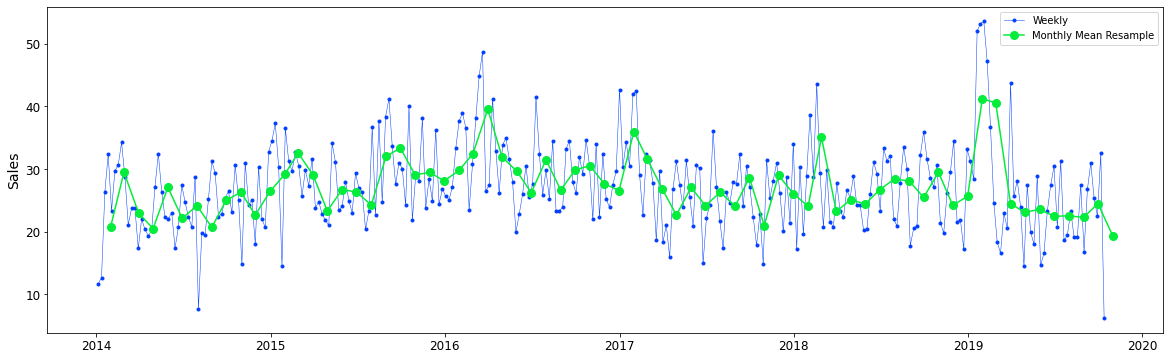

In [6]:
y = df['M01AE']
fig, ax = plt.subplots(figsize=(20, 6))
ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.set_ylabel('Sales')
ax.legend();

##### mean is not constant, variance is altering, and some seasonality is also visible

# Decomposing the Data

##### To visualize trend, seasonality and residual of data

In [9]:
# graphs to show seasonal_decompose
def seasonal_decompose (y):
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()

In [10]:
seasonal_decompose(y)

##### trend is not constant and yearly seasonality is present

# Partial autocorrelation & Autocorrelation

##### To determine randomness and stationarity of the time series

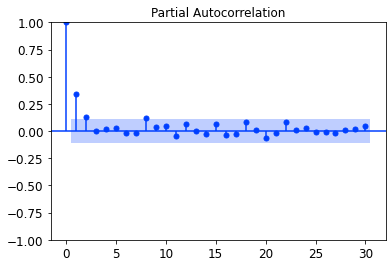

In [12]:
pacf_plot = plot_pacf(df['M01AE'] , lags=30)

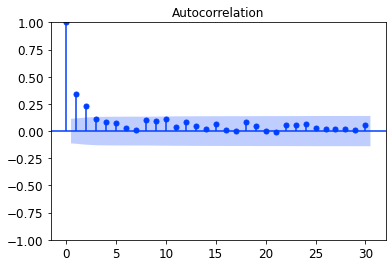

In [13]:
acf_plot = plot_acf(df['M01AE'] , lags=30)

# Checking Stationarity

### Visualization: Graphing the rolling statistics

In [14]:
### plot for Rolling Statistic for testing Stationarity
def test_stationarity(timeseries, title):
    
    #Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean() 
    rolstd = pd.Series(timeseries).rolling(window=12).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='rolling mean');
    ax.plot(rolstd, label='rolling std (x10)');
    ax.legend()

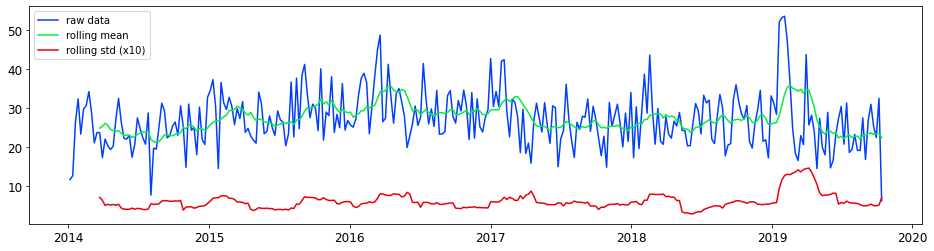

In [15]:
pd.options.display.float_format = '{:.8f}'.format
test_stationarity(y,'raw data')

##### both the mean and the standard deviation are changing over time

### Augmented Dickey-Fuller Test

In [16]:
# Augmented Dickey-Fuller Test

def ADF_test(timeseries, dataDesc):
    print(' > Is the {} stationary ?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Test statistic = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Critical values :')
    for k, v in dftest[4].items():
        print('\t{}: {} - The data is {} stationary with {}% confidence'.format(k, v, 'not' if v<dftest[0] else '', 100-int(k[:-1])))

In [17]:
ADF_test(y,'raw data')

 > Is the raw data stationary ?
Test statistic = -8.739
P-value = 0.000
Critical values :
	1%: -3.4523371197407404 - The data is  stationary with 99% confidence
	5%: -2.871222860740741 - The data is  stationary with 95% confidence
	10%: -2.571929211111111 - The data is  stationary with 90% confidence


### KPSS

In [46]:
def kpss_test(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

kpss_test(df["M01AE"], regression="ct", nlags="auto")

KPSS Statistic: 0.25247064209850045
p-value: 0.01
num lags: 7
Critial Values:
   10% : 0.119
   5% : 0.146
   2.5% : 0.176
   1% : 0.216
Result: The series is not stationary


# Detrending

##### removes underlying trend of the time series

In [26]:
# Detrending
y_detrend =  (y - y.rolling(window=12).mean())/y.rolling(window=12).std()

test_stationarity(y_detrend,'de-trended data')
ADF_test(y_detrend,'de-trended data')

 > Is the de-trended data stationary ?
Test statistic = -14.627
P-value = 0.000
Critical values :
	1%: -3.453102162983312 - The data is  stationary with 99% confidence
	5%: -2.871558538275452 - The data is  stationary with 95% confidence
	10%: -2.5721082282996433 - The data is  stationary with 90% confidence


# Differencing

##### removes underlying seasonal or cyclical pattern of the time series

 > Is the differenced data stationary ?
Test statistic = -9.576
P-value = 0.000
Critical values :
	1%: -3.4529449243622383 - The data is  stationary with 99% confidence
	5%: -2.871489553425686 - The data is  stationary with 95% confidence
	10%: -2.572071437887033 - The data is  stationary with 90% confidence


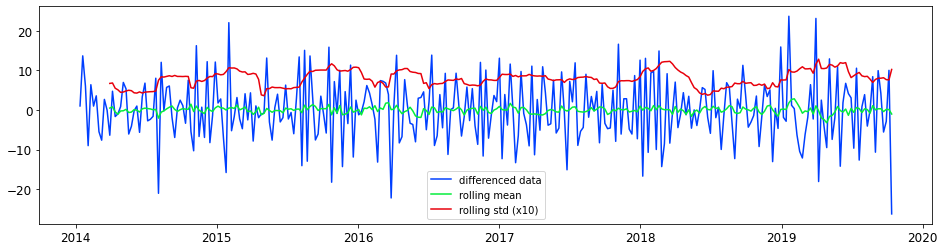

In [28]:
# Differencing
first_diff = df['M01AE'].diff()
test_stationarity(first_diff,'differenced data')
ADF_test(first_diff,'differenced data')

# Set the y_to_train, y_to_test, and the length of predict units

In [29]:
y_to_train = y[:'2018-01-14'] # dataset to train
y_to_val = y['2018-01-21':] # last X months for test  
predict_date = len(y) - len(y[:'2018-01-21']) # the number of data points for the test set

# Different Time Series Prediction Models

# 1.SARIMA

### Plotting PACF & ACF of first differencing

##### To identify initial p, seasonal P (from PACF) & q, seassonal q (from ACF)

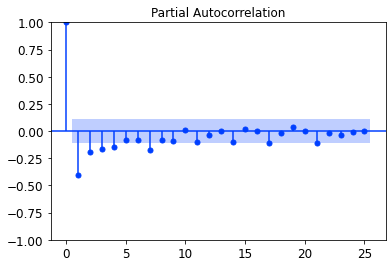

In [95]:
pacf_plot = plot_pacf(df['M01AE'].diff()[1:])

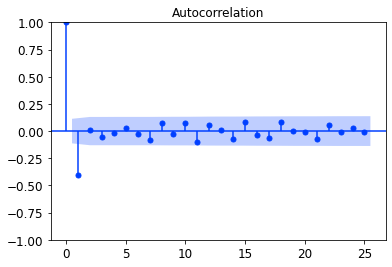

In [96]:
acf_plot = plot_acf(df['M01AE'].diff()[1:])

### Grid search for the combination of (p.d,q) & (P,D,Q)m

In [97]:
import itertools

def sarima_grid_search(y,seasonal_period):
    p = d = q = range(0, 2)
    pdq = list(itertools.product(p, d, q))
    seasonal_pdq = [(x[0], x[1], x[2],seasonal_period) for x in list(itertools.product(p, d, q))]
    
    mini = float('+inf')
    
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                mod = sm.tsa.statespace.SARIMAX(y,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                
                if results.aic < mini:
                    mini = results.aic
                    param_mini = param
                    param_seasonal_mini = param_seasonal

#                 print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    print('The set of parameters with the minimum AIC is: SARIMA{}x{} - AIC:{}'.format(param_mini, param_seasonal_mini, mini))

In [98]:
sarima_grid_search(y,12)

The set of parameters with the minimum AIC is: SARIMA(1, 1, 1)x(0, 1, 1, 12) - AIC:1853.204138932746


### Model fitting, forecasting & evaluation

In [99]:
# Call this function after pick the right(p,d,q) for SARIMA based on AIC               
def sarima_eva(y,order,seasonal_order,seasonal_period,pred_date,y_to_test):
    # fit the model 
    mod = sm.tsa.statespace.SARIMAX(y,
                                order=order,
                                seasonal_order=seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    print(results.summary().tables[1])
    
    results.plot_diagnostics(figsize=(16, 8))
    plt.show()
    
    # The dynamic=False argument ensures that we produce one-step ahead forecasts, 
    # meaning that forecasts at each point are generated using the full history up to that point.
    pred = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=False)
    pred_ci = pred.conf_int()
    y_forecasted = pred.predicted_mean
    mse = ((y_forecasted - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = False {}'.format(seasonal_period,round(np.sqrt(mse), 2)))

    ax = y.plot(label='observed')
    y_forecasted.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')
    plt.legend()
    plt.show()
    # A better representation of our true predictive power can be obtained using dynamic forecasts. 
    # In this case, we only use information from the time series up to a certain point, 
    # and after that, forecasts are generated using values from previous forecasted time points.
    pred_dynamic = results.get_prediction(start=pd.to_datetime(pred_date), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y_forecasted_dynamic = pred_dynamic.predicted_mean
    mse_dynamic = ((y_forecasted_dynamic - y_to_test) ** 2).mean()
    print('The Root Mean Squared Error of SARIMA with season_length={} and dynamic = True {}'.format(seasonal_period,round(np.sqrt(mse_dynamic), 2)))

    ax = y.plot(label='observed')
    y_forecasted_dynamic.plot(label='Dynamic Forecast', ax=ax,figsize=(14, 7))
    ax.fill_between(pred_dynamic_ci.index,
                    pred_dynamic_ci.iloc[:, 0],
                    pred_dynamic_ci.iloc[:, 1], color='k', alpha=.2)

    ax.set_xlabel('Date')
    ax.set_ylabel('Sessions')

    plt.legend()
    plt.show()
    
    return (results)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2807      0.057      4.966      0.000       0.170       0.392
ma.L1         -0.9430      0.026    -36.279      0.000      -0.994      -0.892
ma.S.L12      -1.0819      0.068    -15.990      0.000      -1.215      -0.949
sigma2        38.6339      5.319      7.263      0.000      28.209      49.059


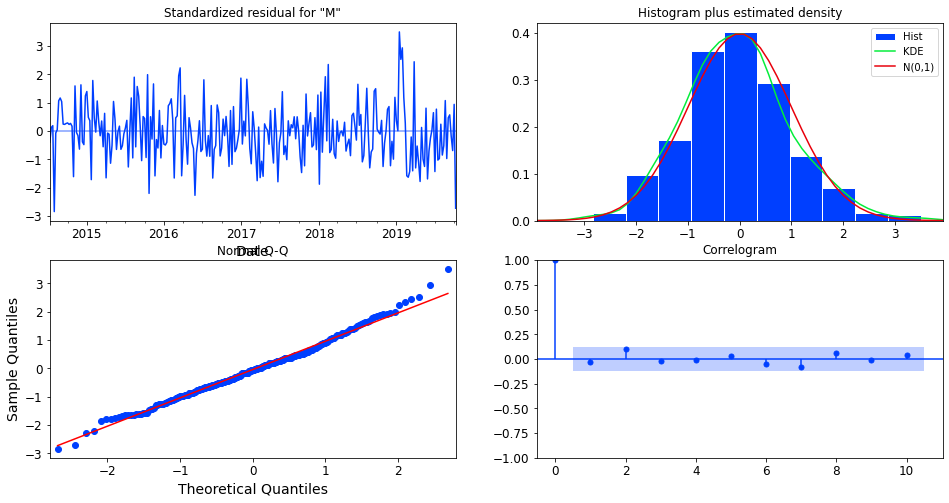

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = False 7.47


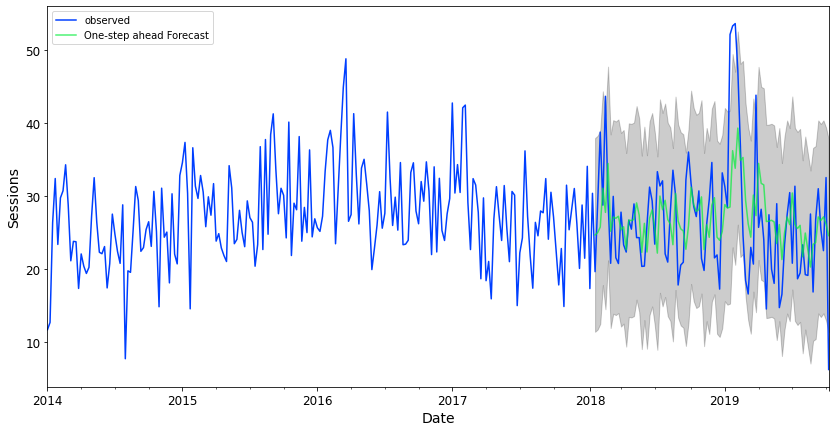

The Root Mean Squared Error of SARIMA with season_length=12 and dynamic = True 8.17


In [100]:
model = sarima_eva(y,(1, 1, 1),(0, 1, 1, 12),12,'2018-01-21',y_to_val)

# Making Predictions

In [107]:
def forecast(model,predict_steps,y): #predict_steps = 12 weeks(3 months)
    
    pred_uc = model.get_forecast(steps=predict_steps)

    pred_ci = pred_uc.conf_int()

    ax = y.plot(label='observed', figsize=(14, 7))
    #print(pred_uc.predicted_mean)
    pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='k', alpha=.05)
    ax.set_xlabel('Date')
    ax.set_ylabel(y.name)

    plt.legend()
    plt.show()
    
    # Produce the forcasted tables 
    pm = pred_uc.predicted_mean.reset_index()
    pm.columns = ['Date','Predicted_Mean']
    pci = pred_ci.reset_index()
    pci.columns = ['Date','Lower Bound','Upper Bound']
    final_table = pm.join(pci.set_index('Date'), on='Date')
    
    return (final_table)

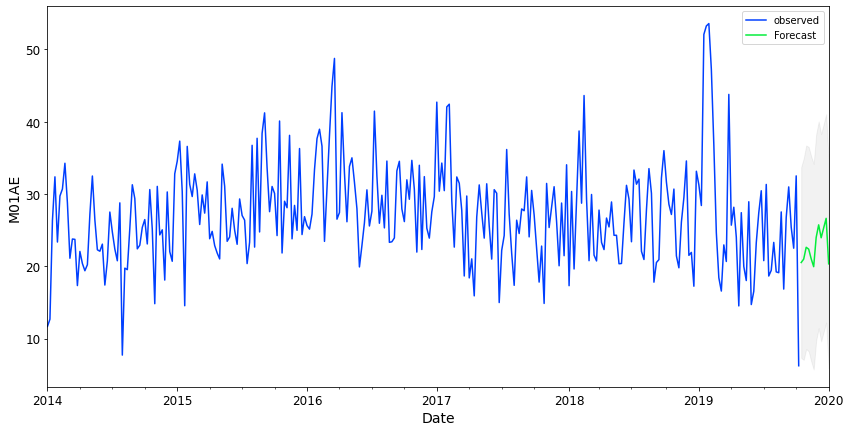

Date  Predicted_Mean  Lower Bound  Upper Bound
0 2019-10-20     20.51857345   7.31783748  33.71930943
1 2019-10-27     20.98731112   7.05345652  34.92116572
2 2019-11-03     22.62499812   8.54757647  36.70241977
3 2019-11-10     22.36824602   8.22950750  36.50698455
4 2019-11-17     21.03890086   6.85576461  35.22203710

In [102]:
final_table = forecast(model,12,y)
final_table.head()

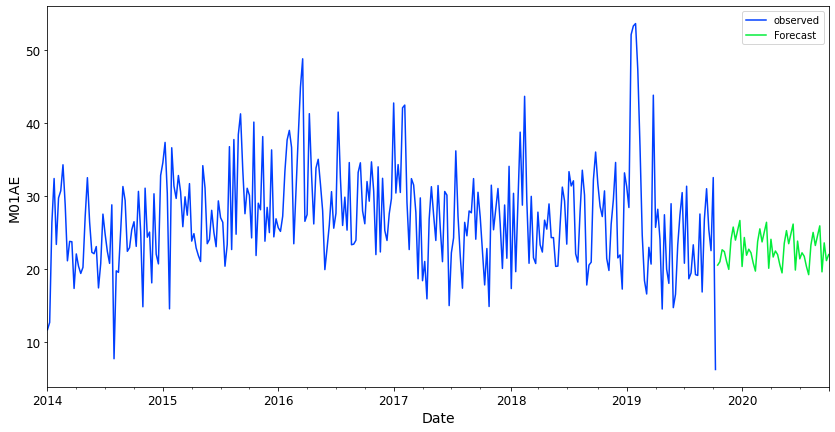

In [108]:
### Graphs without the confident interval 
pred_uc = model.get_forecast(steps=51)
ax = y.plot(label='observed', figsize=(14, 7))
#print(pred_uc.predicted_mean)
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel(y.name)

plt.legend()
plt.show()

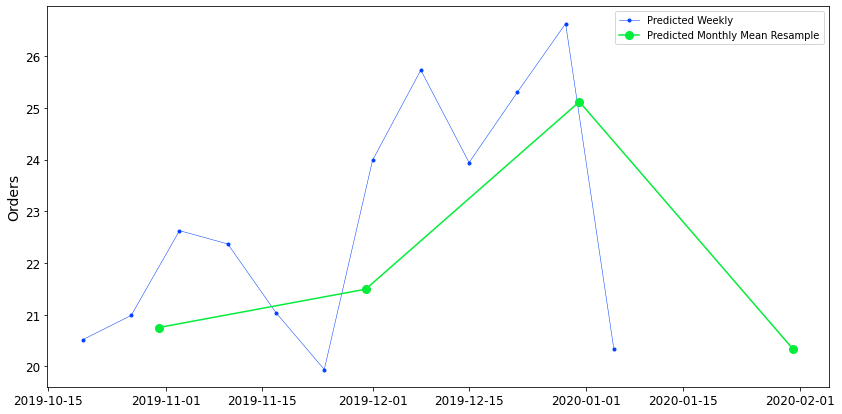

In [109]:
### Graphs show only the perdiected period
final_table.index = final_table.Date
fig, ax = plt.subplots( figsize=(14, 7))
# ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Weekly')
ax.plot(final_table.Predicted_Mean,marker='.', linestyle='-', linewidth=0.5, label='Predicted Weekly')
# ax.plot(y.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Monthly Mean Resample')
ax.plot(final_table.Predicted_Mean.resample('M').mean(),marker='o', markersize=8, linestyle='-', label='Predicted Monthly Mean Resample')
ax.set_ylabel('Orders')
ax.legend();

# 2.Prophet Model

In [329]:
import warnings; 
warnings.simplefilter('ignore')
import pandas as pd
import prophet
from prophet.plot import plot_plotly,plot_components_plotly
from prophet import Prophet
from statsmodels.tools.eval_measures import rmse

# Load & preprocess data

In [330]:
#load the dataset
df_daily = pd.read_csv("C:\\Users\\User\\Desktop\\Ryerson\\CIND 820\\Dataset\\salesdaily.csv")
df_daily.drop(['Year','Month','Hour','Weekday Name','M01AB', 'N02BA', 'N02BE', 'N05B', 'N05C', 'R03','R06'], axis=1, inplace=True)
df_daily['datum'] = pd.to_datetime(df_daily['datum'])
df_daily.rename(columns = {'datum':'Date'}, inplace = True)

df_daily.head()

Date  M01AE
0 2014-01-02   3.67
1 2014-01-03   4.00
2 2014-01-04   1.00
3 2014-01-05   3.00
4 2014-01-06   1.00

In [331]:
df_daily.columns = ['ds', 'y']
df_daily.head()

ds    y
0 2014-01-02 3.67
1 2014-01-03 4.00
2 2014-01-04 1.00
3 2014-01-05 3.00
4 2014-01-06 1.00

# Create the model

### a.Train,Test Split

In [115]:
train = df_daily.iloc[:len(df_daily)-631]
test = df_daily.iloc[len(df_daily)-631:]

### b.Fitting the model & making predictions

##### yearly seasonality is present so yearly_seasonality=True and from test to prediction there are 25 months so periods=25

In [116]:
m = Prophet(interval_width=0.95, yearly_seasonality=True)
m.fit(train)
future = m.make_future_dataframe(periods=25,freq='M') #starting from test time upto predicted time it is 25 months
forecast = m.predict(future)
forecast.tail()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
1495 2019-09-30 2.89164372 -1.49785250  6.59115441   2.56503942   3.26694846   
1496 2019-10-31 2.85477981 -1.90452244  6.24304950   2.49941632   3.25436879   
1497 2019-11-30 2.81910505 -0.80328623  7.00845004   2.43429619   3.25437221   
1498 2019-12-31 2.78224114 -1.19758199  6.88988238   2.36769747   3.24736342   
1499 2020-01-31 2.74537723 -0.91000464  7.46115519   2.30119650   3.23953554   

      additive_terms  additive_terms_lower  additive_terms_upper      weekly  \
1495     -0.23691749           -0.23691749           -0.23691749 -0.16277576   
1496     -0.57766845           -0.57766845           -0.57766845 -0.28266530   
1497      0.23043135            0.23043135            0.23043135  0.53295134   
1498     -0.06157979           -0.06157979           -0.06157979 -0.33218915   
1499      0.79098337            0.79098337            0.79098337 -0.10847099   

      weekly_lower  weekly_upper      yearly  yearly_lower  yearly_upper  \
1495   -0.16277576   -0.16277576 -0.07414172   -0.07414172   -0.07414172   
1496   -0.28266530   -0.28266530 -0.29500315   -0.29500315   -0.29500315   
1497    0.53295134    0.53295134 -0.30251999   -0.30251999   -0.30251999   
1498   -0.33218915   -0.33218915  0.27060936    0.27060936    0.27060936   
1499   -0.10847099   -0.10847099  0.89945437    0.89945437    0.89945437   

      multiplicative_terms  multiplicative_terms_lower  \
1495            0.00000000                  0.00000000   
1496            0.00000000                  0.00000000   
1497            0.00000000                  0.00000000   
1498            0.00000000                  0.00000000   
1499            0.00000000                  0.00000000   

      multiplicative_terms_upper       yhat  
1495                  0.00000000 2.65472624  
1496                  0.00000000 2.27711136  
1497                  0.00000000 3.04953640  
1498                  0.00000000 2.72066135  
1499                  0.00000000 3.53636060

In [117]:
forecast[['ds','yhat','yhat_lower','yhat_upper']].tail()

ds       yhat  yhat_lower  yhat_upper
1495 2019-09-30 2.65472624 -1.49785250  6.59115441
1496 2019-10-31 2.27711136 -1.90452244  6.24304950
1497 2019-11-30 3.04953640 -0.80328623  7.00845004
1498 2019-12-31 2.72066135 -1.19758199  6.88988238
1499 2020-01-31 3.53636060 -0.91000464  7.46115519

### c.Visualizing the forecast 

In [118]:
plot_plotly(m,forecast)

##### in the plot,forecasted data did not fit that well to the actual data and some outliers are also present.

### d.Visualizing the trend

In [119]:
plot_components_plotly(m,forecast)

##### the trend is decreasing and yearly and weekly seasonality is clearly visible

# Evaluate the model

In [120]:
predictions = forecast.iloc[-631:]['yhat']
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))

Root Mean Squared Error between actual and  predicted values:  2.2812930115720684


# 3.SVR model

In [361]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math
import plotly.graph_objects as go 
import plotly.express as px


from sklearn.svm import SVR

from sklearn.preprocessing import MinMaxScaler
from IPython.display import Image

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages

# Load the dataset

In [362]:
#load the dataset
df_daily = pd.read_csv("C:\\Users\\User\\Desktop\\Ryerson\\CIND 820\\Dataset\\salesdaily.csv")
df_daily.drop(['Year','Month','Hour','Weekday Name'], axis=1, inplace=True)

df_daily['datum'] = pd.to_datetime(df_daily['datum'])
df_daily.rename(columns = {'datum':'Date'}, inplace = True)
# Set the date as index 
df_daily = df_daily.set_index('Date')
df_daily.head()

M01AB  M01AE  N02BA  N02BE  N05B  N05C   R03  R06
Date                                                         
2014-01-02   0.00   3.67   3.40  32.40  7.00  0.00  0.00 2.00
2014-01-03   8.00   4.00   4.40  50.60 16.00  0.00 20.00 4.00
2014-01-04   2.00   1.00   6.50  61.85 10.00  0.00  9.00 1.00
2014-01-05   4.00   3.00   7.00  41.10  8.00  0.00  3.00 0.00
2014-01-06   5.00   1.00   4.50  21.70 16.00  2.00  6.00 2.00

### Plotting the data

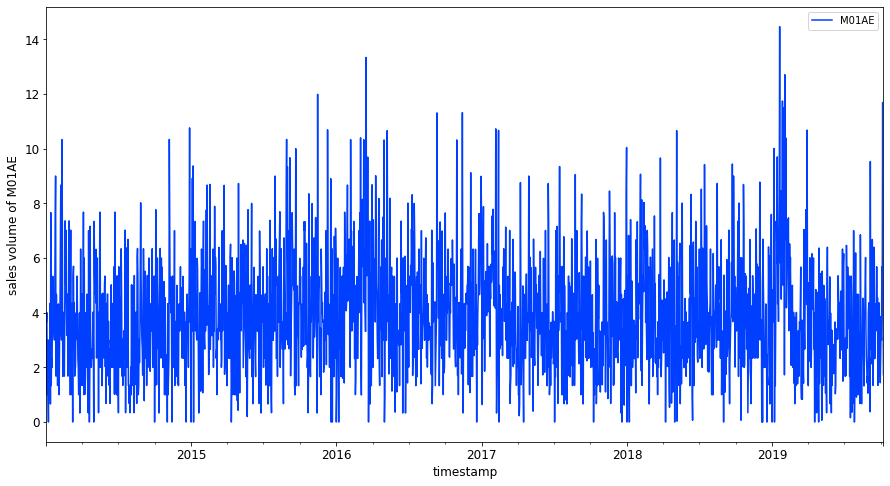

In [364]:
df_daily.plot(y='M01AE', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('sales volume of M01AE', fontsize=12)
plt.show()

### Create training and testing datasets

In [365]:
train_start_dt = '2014-01-02'
test_start_dt = '2018-01-16'

### Visualize the differences

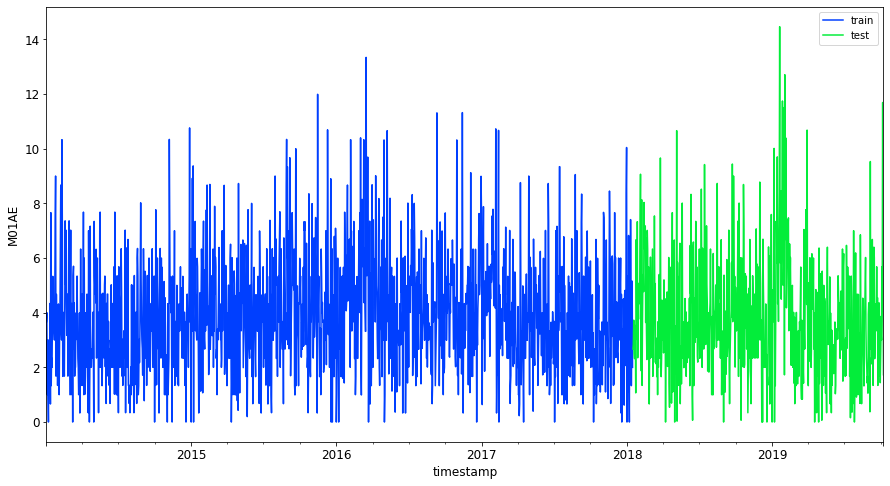

In [366]:
df_daily[(df_daily.index < test_start_dt) & (df_daily.index >= train_start_dt)][['M01AE']].rename(columns={'M01AE':'train'}) \
    .join(df_daily[test_start_dt:][['M01AE']].rename(columns={'M01AE':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('M01AE', fontsize=12)
plt.show()

### Prepare the data for training

In [367]:
train = df_daily.copy()[(df_daily.index >= train_start_dt) & (df_daily.index < test_start_dt)][['M01AE']]
test = df_daily.copy()[df_daily.index >= test_start_dt][['M01AE']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1475, 1)
Test data shape:  (631, 1)


In [368]:
# Scale the data to be in the range (0, 1)
scaler = MinMaxScaler()
train['M01AE'] = scaler.fit_transform(train)
train.head()

M01AE
Date             
2014-01-02   0.28
2014-01-03   0.30
2014-01-04   0.07
2014-01-05   0.22
2014-01-06   0.07

In [369]:
test['M01AE'] = scaler.fit_transform(test)
test.head(5)

M01AE
Date             
2018-01-16   0.18
2018-01-17   0.20
2018-01-18   0.26
2018-01-19   0.17
2018-01-20   0.16

### Create data with time-steps

In [370]:
# Converting to numpy arrays
train_data = train.values
test_data = test.values
timesteps=5

In [371]:
#Converting training data to 2D tensor 
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(1471, 5)

In [372]:
#Converting testing data to 2D tensor
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(627, 5)

In [373]:
#Selecting inputs and outputs from training and testing data
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1471, 4) (1471, 1)
(627, 4) (627, 1)


### Hyperparameter tunning

In [374]:
model = SVR()

In [375]:
param_grid = {'kernel':['rbf'],'gamma': [0.1,0.01,0.001] , 'C':[0.1,1,10],'epsilon':[0.05,0.1]}

In [346]:
grid = GridSearchCV(SVR(),param_grid,refit = True, verbose = 3)

In [376]:
grid.fit(x_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.039 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.007 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.087 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.079 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.05, gamma=0.1, kernel=rbf;, score=-0.030 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.058 total time=   0.0s
[CV 2/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.005 total time=   0.0s
[CV 3/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.103 total time=   0.0s
[CV 4/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.084 total time=   0.0s
[CV 5/5] END C=0.1, epsilon=0.05, gamma=0.01, kernel=rbf;, score=-0.018 total time=   0.0s
[CV 1/5] END C=0.1, epsilon=0.05, 

GridSearchCV(estimator=SVR(),
             param_grid={'C': [0.1, 1, 10], 'epsilon': [0.05, 0.1],
                         'gamma': [0.1, 0.01, 0.001], 'kernel': ['rbf']},
             verbose=3)

In [377]:
grid.best_params_

{'C': 10, 'epsilon': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}

### Fit the model on training data

In [378]:
model = SVR(kernel='rbf',gamma=0.01, C=10, epsilon = 0.1)
model.fit(x_train, y_train[:,0])

SVR(C=10, gamma=0.01)

### Making predictions

In [379]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(1471, 1) (627, 1)


### Evaluate the model

In [380]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

1471 627


In [381]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

1471 627


In [382]:
#Check model performance on training and testing data
train_timestamps = df_daily[(df_daily.index < test_start_dt) & (df_daily.index >= train_start_dt)].index[timesteps-1:]
test_timestamps = df_daily[test_start_dt:].index[timesteps-1:]

print(len(train_timestamps), len(test_timestamps))

1471 627


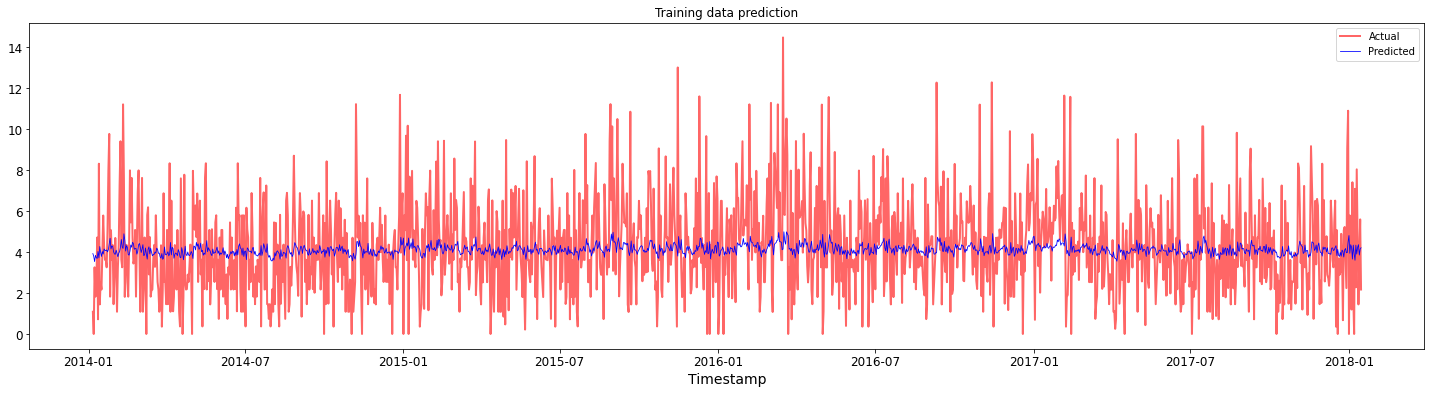

In [383]:
# Plot the predictions for training data
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [384]:
#Print  RMSE for training data

rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')

Root mean squared error: 2.16


In [385]:
#plot the predictions for testing data
plt.figure(figsize=(25,6))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [386]:
#Print RMSE for testing data

rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')

Root mean squared error: 2.16


In [387]:
##Check model performance on full dataset 

# Extracting M01AE sales values as numpy array
data = df_daily.copy().values
data = data.reshape(-1, 1)

# Scaling
data = scaler.transform(data)

# Transforming to 2D tensor as per model input requirement
data_timesteps=np.array([[j for j in data[i:i+timesteps]] for i in range(0,len(data)-timesteps+1)])[:,:,0]
print("Tensor shape: ", data_timesteps.shape)

# Selecting inputs and outputs from data
X, Y = data_timesteps[:,:timesteps-1],data_timesteps[:,[timesteps-1]]
print("X shape: ", X.shape,"\nY shape: ", Y.shape)

Tensor shape:  (16844, 5)
X shape:  (16844, 4) 
Y shape:  (16844, 1)


In [388]:
# Make model predictions
Y_pred = model.predict(X).reshape(-1,1)

# Inverse scale and reshape
Y_pred = scaler.inverse_transform(Y_pred)
Y = scaler.inverse_transform(Y)

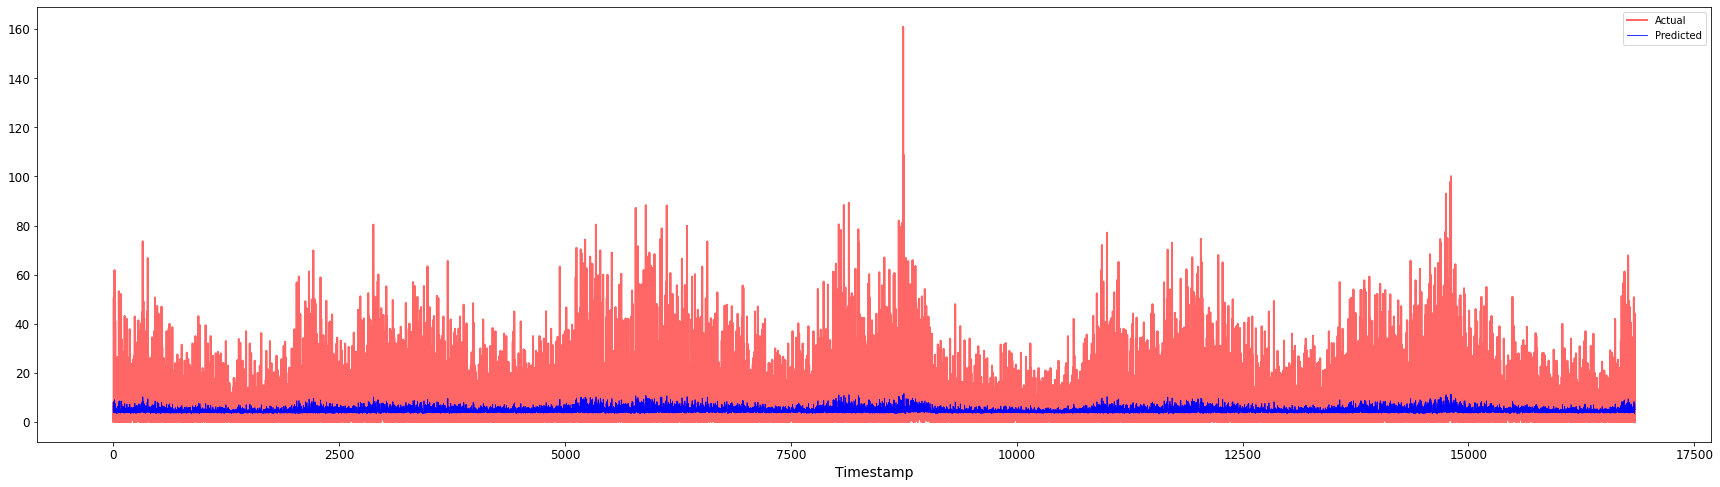

In [389]:
plt.figure(figsize=(30,8))
plt.plot(Y, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(Y_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [390]:
##Print RMSE for full dataset

rmse = np.sqrt(mse)
print(f'Root mean squared error: {rmse:.2f}')

Root mean squared error: 2.16
